<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/export_model/checkpoint_import_lucid_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and imports

In [1]:
%tensorflow_version 1.x

!pip uninstall lucid -y
!pip install git+https://github.com/tensorflow/lucid.git#egg=lucid

!git clone https://github.com/arunraja-hub/Preference_Extraction.git
!cd Preference_Extraction && git checkout export_model

!pip install tf-agents==0.3.0

!pip uninstall tensorflow-probability -y
!pip install tensorflow-probability==0.7.0

!npm install -g svelte-cli@2.2.0

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.
Uninstalling lucid-0.3.8:
  Successfully uninstalled lucid-0.3.8
  Cloning https://github.com/tensorflow/lucid.git to /tmp/pip-install-vz_id7do/lucid
  Running command git clone -q https://github.com/tensorflow/lucid.git /tmp/pip-install-vz_id7do/lucid
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=155742 sha256=f4fb2199e3b7c2f61c833bc6a6ae1fea1e19553b77e5b75e4eb58ce44b07f71d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ifm7r14/wheels/64/c2/51/7238e75f457453774587708b21cd3cf32f9a86456648688634
Successfully built lucid
Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (549/549), done.
remote: Compressing objects: 100% (538/538), done.
remote: Total 549 (delta 27), reused 514 (delta 10), pack-reused 0
Receiving objects: 100% (549/549), 20.54 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Branch 'export_model' set up to track remote branch 'export_model' from

In [2]:
import numpy as np

from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import BoundedTensorSpec
from tf_agents.networks import q_network

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map


import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

import urllib.request
from urllib.error import HTTPError

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


# Examine the checkpoint vars

In [0]:
cpt_name = "Preference_Extraction/model_ckpt"

In [4]:
cpt_var_names = tf.compat.v1.train.list_variables(cpt_name)
[name for name in cpt_var_names if (("bias" in name[0]) or ("kernel" in name[0])) and not ("OPTIMIZER" in name[0])]

[('agent/_q_network/_encoder/_postprocessing_layers/0/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [16]),
 ('agent/_q_network/_encoder/_postprocessing_layers/0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [3, 3, 5, 16]),
 ('agent/_q_network/_encoder/_postprocessing_layers/1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [32]),
 ('agent/_q_network/_encoder/_postprocessing_layers/1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [3, 3, 16, 32]),
 ('agent/_q_network/_encoder/_postprocessing_layers/3/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [64]),
 ('agent/_q_network/_encoder/_postprocessing_layers/3/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [960, 64]),
 ('agent/_q_network/_q_value_layer/bias/.ATTRIBUTES/VARIABLE_VALUE', [3]),
 ('agent/_q_network/_q_value_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [64, 3]),
 ('agent/_target_q_network/_encoder/_postprocessing_layers/0/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [16]),
 ('agent/_target_q_network/_encoder/_postprocessing_layers/0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [3, 3, 5, 16]),
 ('agent/_t

# Setup model

In [5]:
tf.reset_default_graph()

input_shape = [14, 16, 5]

my_input = tf.placeholder(tf.float32, shape=[None] + input_shape, name="my_input")
q_vals = q_network.QNetwork(input_tensor_spec=TensorSpec(shape=(14, 16, 5)), action_spec=BoundedTensorSpec((), tf.int32, 0, 2), conv_layer_params = [[16, 3, 1], [32, 3, 2]], fc_layer_params = [64])(my_input)

[tensor for op in tf.get_default_graph().get_operations() for tensor in op.values()]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[<tf.Tensor 'my_input:0' shape=(?, 14, 16, 5) dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal/mean:0' shape=() dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal/TruncatedNormal:0' shape=(3, 3, 5, 16) dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal/mul:0' shape=(3, 3, 5, 16) dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel/Initializer/truncated_normal:0' shape=(3, 3, 5, 16) dtype=float32>,
 <tf.Tensor 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel:0' shape=() dtype=resource>,
 <tf.Tensor 'QNetwor

# Get the var_name_to_prev_var_name mapping by matching tensors with the same shape.

In [6]:
cpt_var_info = tf.compat.v1.train.list_variables(cpt_name)
cpt_var_info = [var for var in cpt_var_info if (("bias" in var[0]) or ("kernel" in var[0])) and not ("OPTIMIZER" in var[0]) and not ("_target_q_network" in var[0])]

shape_to_cpt_var_name = {tuple(var[1]): var[0] for var in cpt_var_info}
shape_to_cpt_var_name

{(3,): 'agent/_q_network/_q_value_layer/bias/.ATTRIBUTES/VARIABLE_VALUE',
 (3,
  3,
  5,
  16): 'agent/_q_network/_encoder/_postprocessing_layers/0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 (3,
  3,
  16,
  32): 'agent/_q_network/_encoder/_postprocessing_layers/1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 (16,): 'agent/_q_network/_encoder/_postprocessing_layers/0/bias/.ATTRIBUTES/VARIABLE_VALUE',
 (32,): 'agent/_q_network/_encoder/_postprocessing_layers/1/bias/.ATTRIBUTES/VARIABLE_VALUE',
 (64,): 'agent/_q_network/_encoder/_postprocessing_layers/3/bias/.ATTRIBUTES/VARIABLE_VALUE',
 (64, 3): 'agent/_q_network/_q_value_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 (960,
  64): 'agent/_q_network/_encoder/_postprocessing_layers/3/kernel/.ATTRIBUTES/VARIABLE_VALUE'}

In [7]:
current_vars = tf.get_collection(tf.GraphKeys.VARIABLES)
current_vars

shape_to_current_var_name = {tuple(var.get_shape().as_list()): var.name[:-2] for var in current_vars}
shape_to_current_var_name

Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


{(3,): 'QNetwork/dense/bias',
 (3, 3, 5, 16): 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel',
 (3, 3, 16, 32): 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/kernel',
 (16,): 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/bias',
 (32,): 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/bias',
 (64,): 'QNetwork/EncodingNetwork/EncodingNetwork/dense/bias',
 (64, 3): 'QNetwork/dense/kernel',
 (960, 64): 'QNetwork/EncodingNetwork/EncodingNetwork/dense/kernel'}

In [8]:
var_name_to_prev_var_name = {}

for shape in shape_to_current_var_name:
  var_name_to_prev_var_name[shape_to_current_var_name[shape]] = shape_to_cpt_var_name[shape]

var_name_to_prev_var_name

{'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/bias': 'agent/_q_network/_encoder/_postprocessing_layers/0/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d/kernel': 'agent/_q_network/_encoder/_postprocessing_layers/0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/bias': 'agent/_q_network/_encoder/_postprocessing_layers/1/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/kernel': 'agent/_q_network/_encoder/_postprocessing_layers/1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/EncodingNetwork/EncodingNetwork/dense/bias': 'agent/_q_network/_encoder/_postprocessing_layers/3/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/EncodingNetwork/EncodingNetwork/dense/kernel': 'agent/_q_network/_encoder/_postprocessing_layers/3/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/dense/bias': 'agent/_q_network/_q_value_layer/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'QNetwork/dense/kernel': 'agent/_q_n

# Read data

In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
# Modified read trajectories functions to read files from local storage

def load_file(full_path):
    try:
        with open(full_path, 'rb') as f:
            data = rename_load(f)
            return data
    except:
        return None
    
def all_load_data(base_path):
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    
    futures = []
    for i in range(5000):
        full_path = os.path.join(base_path, "ts"+str(i)+".pickle")
        future = executor.submit(load_file, full_path)
        futures.append(future)
    
    raw_data = []
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            raw_data.append(result)
    
    return raw_data


all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

# Do the warmstart and verify it worked

In [11]:
tf.train.warm_start(cpt_name, var_name_to_prev_var_name=var_name_to_prev_var_name)
init_op = tf.global_variables_initializer()

INFO:tensorflow:Warm-starting from: Preference_Extraction/model_ckpt


INFO:tensorflow:Warm-starting from: Preference_Extraction/model_ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 8 variables.


INFO:tensorflow:Warm-started 8 variables.


In [13]:
activation_tensor = tf.get_default_graph().get_tensor_by_name("QNetwork/EncodingNetwork/EncodingNetwork/dense/Relu:0")
weights = tf.get_default_graph().get_tensor_by_name("QNetwork/dense/kernel/Read/ReadVariableOp:0")
bias = tf.get_default_graph().get_tensor_by_name("QNetwork/dense/bias/Read/ReadVariableOp:0")

with tf.Session() as sess:
  sess.run(init_op)

  for i in range(len(all_raw_data[0].observation)):
    single_observation = np.array([all_raw_data[0].observation[i]])

    restored_activations = sess.run(activation_tensor, {my_input: single_observation})[0]
    old_activations = all_raw_data[0].policy_info["activations"][i]

    if i < 3:
      print("restored_activations", restored_activations, "old_activations", old_activations)

    np.testing.assert_allclose(restored_activations, old_activations, rtol=1e-2)

restored_activations [  0.         0.         0.         0.       282.45563    0.
   0.       150.05293    0.         0.         0.        29.24245
   0.         0.         0.         0.         0.         0.
   0.         0.         0.       167.96378    0.         0.
   0.         0.         0.        29.117985   0.         0.
   0.         0.         0.         0.       223.1004     0.
  70.77664    0.         0.         0.         0.         0.
   0.         0.        52.82331    0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.        42.96146    0.         0.      ] old_activations [  0.         0.         0.         0.       282.45563    0.
   0.       150.05296    0.         0.         0.        29.24238
   0.         0.         0.         0.         0.         0.
   0.         0.         0.       167.9638     0.         0.
   0.         0.         0.        29.117958   0.    

# Save Lucid model.

In [14]:
with tf.Session() as sess:
  sess.run(init_op)

  models.Model.suggest_save_args()
  
  models.Model.save(
    input_name='my_input',
    image_shape=input_shape,
    output_names=["QNetwork/EncodingNetwork/EncodingNetwork/dense/Relu"],
    image_value_range=[0,1],
    save_url="lucid_save_model.pb"
  )

Inferred: input_name = my_input (because it was the only Placeholder in the graph_def)
Inferred: image_shape = [14, 16, 5]
# Please sanity check all inferred values before using this code.
# Incorrect `image_value_range` is the most common cause of feature visualization bugs! Most methods will fail silently with incorrect visualizations!
Model.save(
    input_name='my_input',
    image_shape=[14, 16, 5],
    output_names=_,                   # TODO (eg. ['logits'])
    image_value_range=_,                   # TODO (eg. '[-1, 1], [0, 1], [0, 255], or [-117, 138]')
  )



/usr/local/lib/python3.6/dist-packages/lucid/modelzoo/vision_base.py:283: UserWarning: Could not infer output_names.
  warnings.warn("Could not infer output_names.")



Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


INFO:tensorflow:Froze 6 variables.


INFO:tensorflow:Froze 6 variables.


INFO:tensorflow:Converted 6 variables to const ops.


INFO:tensorflow:Converted 6 variables to const ops.


# Lucid HTML stuff.
Copied from https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/NeuronGroups.ipynb

In [15]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_ulxdok43/GroupWidget_26ca7b20_bb3b_492b_b0e2_a658d662167b.html > /tmp/svelte_ulxdok43/GroupWidget_26ca7b20_bb3b_492b_b0e2_a658d662167b.js
b'svelte version 1.64.1\ncompiling ../tmp/svelte_ulxdok43/GroupWidget_26ca7b20_bb3b_492b_b0e2_a658d662167b.html...\n(4:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(6:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(14:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(27:6) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n'


# Load model and run lucid grouping code

In [0]:
model = models.Model.load("lucid_save_model.pb")
model.load_graphdef()

In [17]:
# This is modified from the neuron_groups funciton in https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/NeuronGroups.ipynb to handle 5 channels instead of 3.

img = single_observation[0]
layer = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d/Relu"
n_groups=6

# Compute activations

with tf.Graph().as_default(), tf.Session():
  t_input = tf.placeholder_with_default(img, input_shape, name="lucid_placeholder")
  T = render.import_model(model, t_input, t_input)
  acts = T(layer).eval()

# We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
# to apply Non-Negative Matrix factorization (NMF).

nmf = ChannelReducer(n_groups, "NMF")
spatial_factors = nmf.fit_transform(acts)[0]
spatial_factors = spatial_factors.transpose(2, 0, 1).astype("float32")
channel_factors = nmf._reducer.components_.astype("float32")

# Let's organize the channels based on their horizontal position in the image

x_peak = np.argmax(spatial_factors.max(1), 1)
ns_sorted = np.argsort(x_peak)
spatial_factors = spatial_factors[ns_sorted]
channel_factors = channel_factors[ns_sorted]

# And create a feature visualziation of each group

param_f = lambda: param.image(80, batch=n_groups, channels=input_shape[-1])
obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
          for i in range(n_groups))
group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]

# We'd also like to know about attribution

# First, let's turn each group into a vector over activations
group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
              for i in range(n_groups)]

# attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
#                    for attr_class in attr_classes])

# print(attrs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



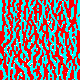
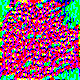
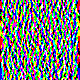
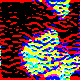
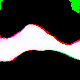
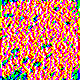

In [19]:
# Let's render the visualization!

lucid_svelte.GroupWidget({
  "img" : _image_url(img[:, :, :3]),
  "n_groups": n_groups,
  "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
  "group_icons": [_image_url(icon) for icon in group_icons[:, :, :, :3]] 
})
